#### ATTENTION! - this notebook doesn't build the dataset. the sole purpose of this notebook is to train the GRU network and to predict question over images. (go to Download datasets.ipynb if you need to update specific files or split to train\test sets) 

In [25]:
import glob,os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import image, sequence
import nltk
import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.models as models
# from torch.utils.tensorboard import SummaryWriter
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
Create_FILES = False
to_train=False
UNKOWN_TOKEN = '<.UNKOWN.>'
created_files_dir = 'vqg_created_files/'

In [27]:
token = 'VQg_text/VQG.token.txt'
captions = open(token, 'r').read().strip().split('\n')

print("num samples: ",len(captions))
captions[:5]

num samples:  74098


['d9d0f748-0b08-4044-8e43-25eb43da3040.jpg#0\tWhat grade is in this classroom',
 'd9d0f748-0b08-4044-8e43-25eb43da3040.jpg#1\tHow many children attend this class',
 'd9d0f748-0b08-4044-8e43-25eb43da3040.jpg#2\tIs this a preschool',
 'd9d0f748-0b08-4044-8e43-25eb43da3040.jpg#3\tWhy is there only two kids',
 'd9d0f748-0b08-4044-8e43-25eb43da3040.jpg#4\tHow much is the preschool']

## Creating a dictionary containing all the captions of the images

In [28]:
MIN_COUNT = 3


vocabulary = [y for x in captions for y in x.split('\t')[1].split()]
fdist = nltk.FreqDist(vocabulary) #count the frequency of words

image_question_dict = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    row[1] = ' '.join([UNKOWN_TOKEN if fdist[x] < MIN_COUNT else x for x in row[1].split()])
    if row[0] in image_question_dict:
        if random.random()<0.5: # choose randomaly if to replace exsiting quest or to preserve last saved question
            #image_question_dict[row[0]].append(row[1]) # uncomment this line (and comment the next one) if you want to append everything 
            image_question_dict[row[0]]=[row[1]]
    else:
        image_question_dict[row[0]] = [row[1]]
image_question_dict['36096576__798005.jpg']

['What <.UNKOWN.> do these people belong to']

In [29]:
images = 'VQg_Dataset/VQG_Dataset/'
# Contains all the images
img_paths = glob.glob(images+'*.*')
img_paths[:5]

['VQg_Dataset/VQG_Dataset\\00051bba-46a4-4aac-876d-5c18bb32fc74.jpg',
 'VQg_Dataset/VQG_Dataset\\00148e4c-3ff4-48e8-bb5c-5bf0ebc08c16.jpg',
 'VQg_Dataset/VQG_Dataset\\001e8ec8-3b00-4396-a321-c00f9afe4de1.jpg',
 'VQg_Dataset/VQG_Dataset\\0043f1ba-1028-4d37-9a7e-4f2204978749.jpg',
 'VQg_Dataset/VQG_Dataset\\00472679-97c5-449a-9ece-4d55370344f4.jpg']

In [30]:
def split_data(l):
    temp = []
    for i in img_paths:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [31]:
# Getting the training images from all the images
train_images_file = 'VQg_text/train.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = split_data(train_images)
print('num of training images',len(train_img))

# Getting the validation images from all the images
val_images_file = 'VQg_text/val.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_img = split_data(val_images)
print('num of validation images',len(val_images))

# Getting the testing images from all the images
test_images_file = 'VQg_text/test.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
print('num of test images',len(test_images))

num of training images 6465
num of validation images 3708
num of test images 3699


We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [32]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return x

# plt.imshow(np.squeeze(preprocess(train_img[0])))

# Load pretrained CNN Model 

In [33]:
# if Create_FILES:
cnn = models.vgg16(pretrained=True)

for param in cnn.parameters():
    param.requires_grad = False

cnn.classifier[5] = nn.Identity()
cnn.classifier[6] = nn.Identity()
new_model = cnn.to(device)
print(new_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [34]:
def encode(image):
    image = torch.from_numpy(preprocess(image))
    image = image.permute(2,0,1)
    image = image.reshape(1,*image.shape).to(device)
    temp_enc = new_model(image).squeeze(0)
    
    return temp_enc

def encode_dataset(data_set, problematic_images):
    '''
    encode the images usng the pretrained CNN model we loaded for faster training
    '''
    encodings = {}
    for img in tqdm(data_set):
        try:
            im_name = img[len(images):]
            encodings[im_name] = encode(img)
        except:
            problematic_images += img+"\n"
    
    return encodings, problematic_images

In [35]:
if Create_FILES:
    '''
    On first time set Create_FILES=True so the encoded images will be created.
    '''
    problematic_images = ''
    encoding_train, problematic_images = encode_dataset(train_img, problematic_images)
    encoding_test, problematic_images = encode_dataset(test_img, problematic_images)
    encoding_val, problematic_images = encode_dataset(val_img, problematic_images)

    print('train: {} test: {} val: {}'.format(len(encoding_train),len(encoding_test),len(encoding_val)))
    print("problematic images: ",len(problematic_images.split('\n')))

if not os.path.exists(created_files_dir):
    os.mkdir(created_files_dir)    

In [36]:
def get_captions_for_dataset(data_set):
    res = {}
    for i in data_set:
        if i[len(images):] in image_question_dict:
            res[i] = image_question_dict[i[len(images):]]
    return res

## Load Encoded images and questions

In [37]:
train_d = get_captions_for_dataset(train_img)
val_d = get_captions_for_dataset(val_img)
test_d = get_captions_for_dataset(test_img)

if Create_FILES:

    encoding_train = pickle.load(open(created_files_dir+'encoded_images_train_vgg16.p', 'rb'))
    encoding_val   = pickle.load(open(created_files_dir + 'encoded_images_val_vgg16.p', 'rb'))
    encoding_test  = pickle.load(open(created_files_dir+'encoded_images_test_vgg16.p', 'rb'))

    with open(created_files_dir + "img.pickle","wb")  as fh:
        pickle.dump(img_paths,fh)

    with open(created_files_dir + "image_question_dict.pickle","wb")  as fh:
        pickle.dump(image_question_dict,fh)

    with open(created_files_dir + "train_img.pickle","wb")  as fh:
        pickle.dump(train_img,fh)

    with open(created_files_dir + "train_d.pickle","wb")  as fh:
        pickle.dump(train_d,fh)

    with open(created_files_dir + "val_img.pickle","wb")  as fh:
        pickle.dump(val_img,fh)

    with open(created_files_dir + "val_d.pickle","wb")  as fh:
        pickle.dump(val_d,fh)

    with open(created_files_dir + "test_img.pickle","wb")  as fh:
        pickle.dump(test_img,fh)

    with open(created_files_dir + "test_d.pickle","wb")  as fh:
        pickle.dump(test_d,fh)

    print('train: {} test: {} val: {}'.format(len(encoding_train),len(encoding_test),len(encoding_val)))

Calculating the unique words in the vocabulary.

In [38]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')
        
if Create_FILES:
    with open(created_files_dir + "caps.pickle","wb")  as fh:
        pickle.dump(caps,fh)
    print("all sentences:",len(caps))
    words = [i.split() for i in caps]
    words.append('?')
    unique = []
    for i in tqdm(words):
        unique.extend(i)
    unique = list(set(unique))
    vocab_size = len(unique)

    with open(created_files_dir+"unique.p", "wb") as pickle_d:
        pickle.dump(unique, pickle_d) 
    
unique = pickle.load(open(created_files_dir+'unique.p', 'rb'))
vocab_size = len(unique)

print('{} unique word'.format(vocab_size))

4729 unique word


Mapping the unique words to indices and vice-versa

In [39]:
word2idx = {val:index for index, val in enumerate(unique)}

with open(created_files_dir + "word2idx.pickle","wb")  as fh:
    pickle.dump(word2idx,fh)
    
idx2word = {index:val for index, val in enumerate(unique)}

with open(created_files_dir + "idx2word.pickle","wb")  as fh:
    pickle.dump(idx2word,fh)

Calculating the maximum length among all the captions

In [40]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)

with open(created_files_dir+"max_len.pickle","wb") as fh:
    pickle.dump(max_len,fh)
    

print('max length', max_len)

max length 21


Adding 'start' and 'end' to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [41]:
def word2idx_with_unkown(word2idx,x):
    '''
    return the idx of unkown token if the work is not known
    '''
    try:
        if x in word2idx:
            return word2idx[x]
        else:
            return word2idx[UNKOWN_TOKEN]
    except:
        print("shit",x)

def create_dataframe(dataset, filename, encoding):
    '''
    This fucntion created a pandas dataframe that holds our dataset.
    one dataframe from the encoded, the other for the question and then join them togather
    to create one set
    '''
    # Wrap captions with <start> and <end>
    with open(created_files_dir + filename, 'w') as f:
        f.write("image_id\tcaptions\n")
        for key, val in dataset.items():
            for i in val:
                f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")
                
    # create dataframe
    df = pd.read_csv(created_files_dir + filename, delimiter='\t')
    df_encoded = pd.DataFrame.from_dict(encoding, orient='index')
    
    df['captions_idx'] = df['captions'].apply(lambda x: [word2idx_with_unkown(word2idx,i) for i in x.split()] + list(np.zeros(int(1.5*max_len)-len(x.split()),dtype='Int32') + word2idx['?']))

    ll = []
    for i in encoding:
        ll.append([i,encoding[i]])
    ll_df = pd.DataFrame(ll,columns=['image_id','encoded'])
    joint_df = ll_df.join(df.set_index('image_id'), on='image_id')
    del ll_df
    del df
    return joint_df

In [42]:
if Create_FILES:
    train_df = create_dataframe(train_d, 'VQG_training_dataset.txt', encoding_train)
    val_df   = create_dataframe(val_d,   'VQG_validation_dataset.txt', encoding_val)
    test_df  = create_dataframe(test_d,  'VQG_test_dataset.txt', encoding_test)
    print('done createing data frames')
    def create_tensor_dict(dataframe):
        captions = torch.transpose(torch.stack([torch.tensor(x) for x in dataframe['captions_idx'].values], dim=1),0,1)
        encodings = torch.transpose(torch.stack([torch.tensor(x) for x in dataframe['encoded'].values], dim=1),0,1)

        data_dict = {}
        data_dict['captions']  = captions
        data_dict['encodings'] = encodings
        return data_dict

    train_data = create_tensor_dict(train_df.dropna())  # TODO - we have to make sure all text is available
    val_data   = create_tensor_dict(val_df.dropna())
    test_data  = create_tensor_dict(test_df.dropna())
    print('done createing dictionary')
    torch.save(test_data['captions'], created_files_dir+'test_data_captions.pt')
    torch.save(test_data['encodings'], created_files_dir+'test_data_encodings.pt')

    torch.save(train_data['captions'], created_files_dir+'train_data_captions.pt')
    torch.save(train_data['encodings'], created_files_dir+'train_data_encodings.pt')

    torch.save(val_data['captions'], created_files_dir+'val_data_captions.pt')
    torch.save(val_data['encodings'], created_files_dir+'val_data_encodings.pt')

In [43]:
list(test_d.keys())[1]

'VQg_Dataset/VQG_Dataset\\001e8ec8-3b00-4396-a321-c00f9afe4de1.jpg'

In [44]:
def load_datasets(path_captions,path_encodings): 
    '''
    This function load the datasets we created previously
    '''
    data_dict = {}
    data_dict['captions']  = torch.load(path_captions).to(device)
    data_dict['encodings'] = torch.load(path_encodings).to(device)
    return data_dict

test_data = load_datasets(created_files_dir+'test_data_captions.pt',created_files_dir+'test_data_encodings.pt')
train_data = load_datasets(created_files_dir+'train_data_captions.pt',created_files_dir+'train_data_encodings.pt')
val_data = load_datasets(created_files_dir+'val_data_captions.pt',created_files_dir+'val_data_encodings.pt')

## Build PyTorch Model

In [45]:
class GRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, fc_size_in,n_layers=1):
        super(GRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.n_layers = n_layers
       
        # Define layers
        self.fc = nn.Linear(fc_size_in,hidden_size)
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, word_input, last_hidden,isBegin):
        # Note: we run this one step at a time (word by word...)     
        # Get the embedding of the current input word (last output word)
        if isBegin:           
            temp= self.fc(last_hidden)

        else:
            temp = last_hidden
                
        word_embedded = self.embedding(word_input).view(1, word_input.size()[0], -1) # S=1 x B x N input of shape (seq_len, batch, input_size):

        # run through LSTM
        rnn_output, hidden = self.gru(word_embedded, temp)
        
        # Final output layer (next word prediction) 
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        output = F.log_softmax(self.out(rnn_output), 1) #outputs are always from the top hidden layer
        
        # Return final output and hidden state
        return output, hidden

In [46]:
# Sanity check with Simple Decoder
#===============================
DECODER_HIDDEN_SIZE = 500
teacher = False
teacher_forcing_ratio = 0.5
batch_size = 128
beam_size = 3

def train_batch(word_inputs_GT,decoder_hidden,decoder,criterion):
    q = ''
    max_length = len(train_data['captions'][0])
    loss = 0
    word_inputs = word_inputs_GT[:,0]
    batch_size = word_inputs_GT.size()[0]
    
    for i in range(max_length):
        word_inputs, decoder_hidden = decoder(word_inputs, decoder_hidden.contiguous(),i==0)
        output_model = word_inputs
        word_inputs = torch.argmax(word_inputs, dim=1).to(device)


        q += idx2word[int(word_inputs[6])] + ' '
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        if use_teacher_forcing:
            if i == len(word_inputs_GT[0]) - 1:
                break
            word_inputs = word_inputs_GT[:,i+1].to(device)
            
        if i < max_length - 1:  # dont train to use <start>
            loss += criterion(output_model, word_inputs_GT[:,i+1])
        else:
            loss += criterion(output_model, torch.LongTensor(np.ones(batch_size) * word2idx['?']).to(device))
    
    q += '?'
    return loss  # divide by batch size (loss per sample)

decoder_test = GRNN(DECODER_HIDDEN_SIZE, 300, vocab_size,4096, 1).to(device)
decoder_hidden = train_data['encodings'][0:batch_size].view(-1,batch_size,4096).to(device)
word_inputs = train_data['captions'][0:batch_size].to(device)

loss = train_batch(word_inputs,decoder_hidden,decoder_test,nn.CrossEntropyLoss())
"loss",loss.item()

('loss', 252.47291564941406)

In [47]:
criterion = nn.CrossEntropyLoss()
LR = 0.0005
teacher_forcing_ratio = 0.5

def init_net(path,LR):
    net = GRNN(DECODER_HIDDEN_SIZE, 300, vocab_size,4096, 1).to(device)
    optimizer = optim.Adam(net.parameters(), lr=LR, betas=[0.9, 0.999])
    
    #tensorbaord specs
#     TENSORBOARD_DIR = str(Path('/home/welad1992/thesis/Data/tensorsumery'))
#     round_log = os.path.join(TENSORBOARD_DIR,str(type(net)).split('.')[1]+str(LR)+path)
#     if not os.path.exists(TENSORBOARD_DIR):
#         os.mkdir(TENSORBOARD_DIR)
#     if not os.path.exists(round_log): 
#         os.mkdir(round_log)

#     writer = SummaryWriter(round_log)
    
    return net,optimizer #,writer

In [48]:
# net,optimizer,writer = init_net('VQG_test',LR)
net,optimizer = init_net('VQG_test',LR)
loss_history_cnn = []
acc_history_cnn = []
best_val_loss = 10000000
max_epochs = 50
batch_size = 128
num_samples = len(train_data['captions'])
print(num_samples)
N = num_samples // batch_size // 10
best_epoch = 0
if to_train:
    # Loop over some hyperparameter
    teacher_forcing_ratio_list = [0.2,0.5,0.7]
    LR_rates = [0.0001,0.0005,0.001,0.005,0.01]

    for teacher_forcing_ratio in teacher_forcing_ratio_list:
        for LR in LR_rates:
            net,optimizer,writer = init_net(str(teacher_forcing_ratio)+'LR'+str(LR),LR)
            print('TR: ',str(teacher_forcing_ratio),'LR: ',str(LR))
            best_val_loss = 10000000
            best_epoch = 0

            for epoch in range(max_epochs):
                if (epoch - best_epoch) > 4:  # early stop
                    break

                running_loss = 0
                running_val_loss = 0.0
                i = 0
                for i in range(num_samples // batch_size):
                    net.train()
                    indices = np.random.choice(num_samples, batch_size)
                    encodings = train_data['encodings'][indices]
                    captions  = train_data['captions'][indices]

                    encodings = encodings.view(-1,batch_size,4096)
                    captions = captions.to(device)
                    encodings = encodings.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    train_loss = train_batch(captions, encodings, net, criterion)
                    train_loss.backward()
                    running_loss += train_loss.item()

                    optimizer.step()

                    if i % N == 0: #evaluate evey N iterations
                        with torch.no_grad():
                            net.eval()
                            encodings_val = val_data['encodings'].view(-1,len(val_data['encodings']),4096).to(device)
                            captions_val  = val_data['captions'].to(device)
                            val_loss = train_batch(captions_val, encodings_val, net, criterion).item() # .item to get the loss value

                        if  val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_net = net
                            best_epoch = epoch


                        writer.add_scalar('train',running_loss/(N+1))
                        writer.add_scalar('val',val_loss)
                        writer.add_scalar('best_val',best_val_loss)
                        print('epoch {}, train_loss {:.2f}, val loss {:.2f}, best_val {:.2f} in epoch {}'.format(epoch, train_loss,val_loss,best_val_loss,best_epoch))
                        running_loss = 0

            torch.save(best_net.state_dict(), created_files_dir+"model_epoch_{}_loss_{}_date_0109_LR_{}_TR_{}.json".format(epoch,best_val_loss,LR,teacher_forcing_ratio)) 
    print('Done Training')


25297


In [134]:
def evaluate_batch(dataset,criterion,net,verbose=False,beam=1):
    '''
    maybe adding:
    @param - batch_size

    '''
    num_samples = len(dataset['captions'])
    max_length = max_len

    loss=0.0
    with torch.no_grad():
        net.eval()
        for sample in range(num_samples):

            encodings = dataset['encodings'][sample]
            captions  = dataset['captions'][sample]

            encodings = encodings.view(-1,1,4096)
            word_inputs = captions.to(device)
            encodings = encodings.to(device)
            word_inputs_GT = word_inputs
            word_inputs = torch.unsqueeze(captions[0],dim=0).to(device)
            decoder_hidden = encodings
            
            candidates = [(1, word_inputs, decoder_hidden, '')]
            
            for i in range(max_length):
                new_candidates = []
                for candidate in candidates:
                    prob, word_inputs, decoder_hidden, question = candidate
                    word_inputs, decoder_hidden = net(word_inputs, decoder_hidden.contiguous(),i==0)
                    output_model = word_inputs

                    best_idx = torch.argsort(word_inputs.squeeze(), descending=True)[:beam]

                    for idx in best_idx:
                        total_prob = prob + word_inputs.squeeze()[idx]
                        new_candi = (total_prob, idx.unsqueeze(dim=0), decoder_hidden, question + idx2word[int(idx)] + ' ')
                        new_candidates.append(new_candi)
                
                candidates = sorted(new_candidates)[-beam:]
            best_sentence = sorted(candidates)[-1][-1]
            
            if verbose:
                print('Question: ',best_sentence)
                if len(dataset['captions'][0])>1:
                    question_GT = [idx2word[int(captions[j])] + ' ' for j in range(max_length)]
                    print('QGT: ',''.join(question_GT[1:]),'\n')

        return True#(loss.item()/max_length)/batch_size



In [54]:
# YOU CAN LOAD THE MODEL WITH THE BEST VAL LOSS:
best_model_path = os.path.join(created_files_dir,"model_epoch_6_loss_21.351837158203125_date_2808.json")
net.load_state_dict(torch.load(best_model_path))
# net = best_net
best_val_loss

10000000

In [55]:
my_test = {}
my_size = 300
my_test['encodings'] = test_data['encodings'][300:300+my_size:5]
my_test['captions'] = test_data['captions'][300:300+my_size:5]
teacher = False
print("test_loss ",evaluate_batch(my_test,criterion,net,verbose=True,beam=5))
print('Done Testing')

Q 0 :  What kind of camera is that <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Are they in a submarine <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ?  

Q 1 :  Who's <.UNKOWN.> is that <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Did you attend this wedding <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ?  

Q 2 :  What kind of device is that <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Is this a <.UNKOWN.> for a gun <end> ? ? ? ? ? ? ? ? ? ? ? ?  

Q 3 :  Who made the design <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Who is that a gift for <end> ? ? ? ? ? ? ? ? ? ? ? ? ?  

Q 4 :  What model plane is that <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Is that plane a <.UNKOWN.> <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ?  

Q 5 :  What kind of horse is that <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  How far did you have to <.UNKOWN.> <end> ? ? ? ? ? ? ? ? ? ? ? ?  

Q 6 :  What are these people cooking <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
QGT:  Is this man transporting bananas <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ?  

Q 7 :  Is that a pi

KeyboardInterrupt: 

## Predict funtion

In [270]:
## Load final Model ##
best_model_path = os.path.join(created_files_dir,"model_epoch_9_loss_22.435476303100586_date_0109_LR_0.001_TR_0.7.json")
net.load_state_dict(torch.load(best_model_path))
final_model=net

1144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question GT:
dict_keys(['VQg_Dataset/VQG_Dataset\\320533.jpg'])
dict_values([['How tall are giraffes']]) 

Greedy search:
Question:  How tall is that giraffe <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
Beam Search, k=5:
Question:  How tall is that giraffe <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
Beam Search, k=7:
Question:  How tall is that giraffe <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 


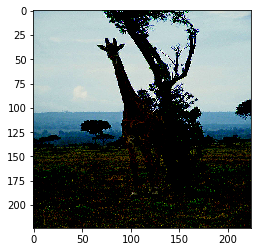

In [272]:
index=random.randint(1,len(test_d)-1)
print(index)
filename = list(test_d.keys())[index]
plt.imshow(np.squeeze(preprocess(filename)))
my_test['encodings'] = encode(filename).view(1,1,4096)
my_test['captions'] = torch.LongTensor([[word2idx['<start>']]])

print('Question GT:')
caption_test = get_captions_for_dataset([filename])
print(caption_test.keys())
print(caption_test.values(),'\n')


print ('Greedy search:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=1)
# print ('Beam Search, k=3:')
# evaluate_batch(my_test,criterion,final_model,verbose=True,beam=3)
print ('Beam Search, k=5:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=5)
print ('Beam Search, k=7:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=7)
pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Question GT:
dict_keys([])
dict_values([]) 

Greedy search:
Question:  What is the couple in the yellow shirt <end> ? ? ? ? ? ? ? ? ? ? ? ? 
Beam Search, k=3:
Question:  Is this a <.UNKOWN.> <.UNKOWN.> <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
Beam Search, k=5:
Question:  What is her name <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 
Beam Search, k=7:
Question:  What is her name <end> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 


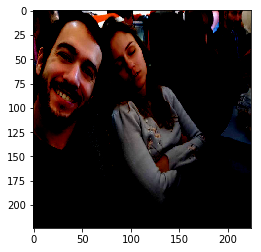

In [268]:
index=80
filename = 'VQg_Dataset/VQG_Dataset/50930589_10216121524483904_3082717303599529984_n.jpg'
# filename = 'VQg_Dataset/VQG_Dataset/11062776_10207428964460293_1330488672886813997_n.jpg'
# filename = list(test_d.keys())[index]
plt.imshow(np.squeeze(preprocess(filename)))
my_test['encodings'] = encode(filename).view(1,1,4096)
my_test['captions'] = torch.LongTensor([[word2idx['<start>']]])

print('Question GT:')
caption_test = get_captions_for_dataset([filename])
print(caption_test.keys())
print(caption_test.values(),'\n')



print ('Greedy search:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=1)
print ('Beam Search, k=3:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=3)
print ('Beam Search, k=5:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=5)
print ('Beam Search, k=7:')
evaluate_batch(my_test,criterion,final_model,verbose=True,beam=7)
pass